In [1]:
from glob import glob
import os, re
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import yaml 

%matplotlib inline

In [2]:
stream = open('../params.yml', 'r')
mydict = yaml.full_load(stream)

base_dir = mydict['folder']
base_input_dir = os.path.join(base_dir, 'test_outputs')

verbose = 0

## sanitized policy in triggered environment

In [4]:
def get_data_for_single_sample_count(sample_dir_path):
    all_csv_files = [file
                 for path, subdir, files in os.walk(sample_dir_path)
                 for file in glob(os.path.join(path, '*.csv'))]
    
    returns_list = []
    for csv_file in all_csv_files:
        results_df = pd.read_csv(csv_file)
        results_df = results_df.loc[:, ~results_df.columns.str.contains('^Unnamed')]
        
        return_list = results_df.groupby(['episode'])['reward'].sum()
        returns_list.append(return_list)
        return returns_list     

In [5]:
sample_trial_return_mean_list, sample_trial_return_std_list = [], []

sanitizing_sample_count_list = [2048, 4096, 12288, 16384, 20480, 20992, 21504, 22016, 22528, 23040, 23552, 24064, 24576, 28672, 32768, 36864]
print(sanitizing_sample_count_list)

for num_sample in sanitizing_sample_count_list:
    if(verbose):
        print('Clean samples : ', num_sample)
    sample_base_dir = os.path.join(base_input_dir, 'clean_sample_'+str(num_sample)+'/sanitized/poison_2000')    
    return_mean_list = []
    for trial in os.listdir(sample_base_dir):
        trial_csv_file = os.path.join(sample_base_dir, trial, 'log', 'csv_data.csv')

        results_csv = pd.read_csv(trial_csv_file)
        return_str = results_csv.loc[results_csv.shape[0]-1, 'return_list']
        return_list = [int(num) for num in re.findall('[0-9]+', return_str)]
        
        return_mean, return_std = np.mean(return_list), np.std(return_list)
        return_mean_list.append(return_mean)
        
        if(verbose):
            print('Mean : {0:2.4f}'.format(return_mean))
    sample_trial_return_mean_list.append(np.mean(return_mean_list)), sample_trial_return_std_list.append(np.std(return_mean_list))

[2048, 4096, 12288, 16384, 20480, 20992, 21504, 22016, 22528, 23040, 23552, 24064, 24576, 28672, 32768, 36864]


In [6]:
st_return_mean_list, st_return_std_list = sample_trial_return_mean_list, sample_trial_return_std_list

## trojan policy in clean environment

In [7]:
sample_base_dir = os.path.join(base_input_dir, 'non_sanitized/no_poison') 

In [8]:
return_mean_list = []
for trial in os.listdir(sample_base_dir):
    trial_csv_file = os.path.join(sample_base_dir, trial, 'log', 'csv_data.csv')

    results_csv = pd.read_csv(trial_csv_file)
    return_str = results_csv.loc[results_csv.shape[0]-1, 'return_list']
    return_list = [int(num) for num in re.findall('[0-9]+', return_str)]

    return_mean, return_std = np.mean(return_list), np.std(return_list)
    return_mean_list.append(return_mean)

    if(verbose):
        print('Mean : {0:2.4f}'.format(return_mean))

In [9]:
tc_return_mean_list, tc_return_std_list = [np.mean(return_mean_list)]*len(sanitizing_sample_count_list), [np.std(return_mean_list)]*len(sanitizing_sample_count_list)

## trojan policy in trigger environmnet

In [10]:
sample_base_dir = os.path.join(base_input_dir, 'non_sanitized/poison_2000') 

In [11]:
return_mean_list = []
for trial in os.listdir(sample_base_dir):
    trial_csv_file = os.path.join(sample_base_dir, trial, 'log', 'csv_data.csv')

    results_csv = pd.read_csv(trial_csv_file)
    return_str = results_csv.loc[results_csv.shape[0]-1, 'return_list']
    return_list = [int(num) for num in re.findall('[0-9]+', return_str)]

    return_mean, return_std = np.mean(return_list), np.std(return_list)
    return_mean_list.append(return_mean)
    if(verbose):
        print('Mean : {0:2.4f}'.format(return_mean))

In [12]:
tt_return_mean_list, tt_return_std_list = [np.mean(return_mean_list)]*len(sanitizing_sample_count_list), [np.std(return_mean_list)]*len(sanitizing_sample_count_list)

In [13]:
# sanitizing_sample_count_list = ['2k', '4k', '12k', '16k', '20.4k', '20.9k', '21.5k', '', '', '', '23.5k', '24k', '24.5k', '28.6k', '32.7k', '36.8k']

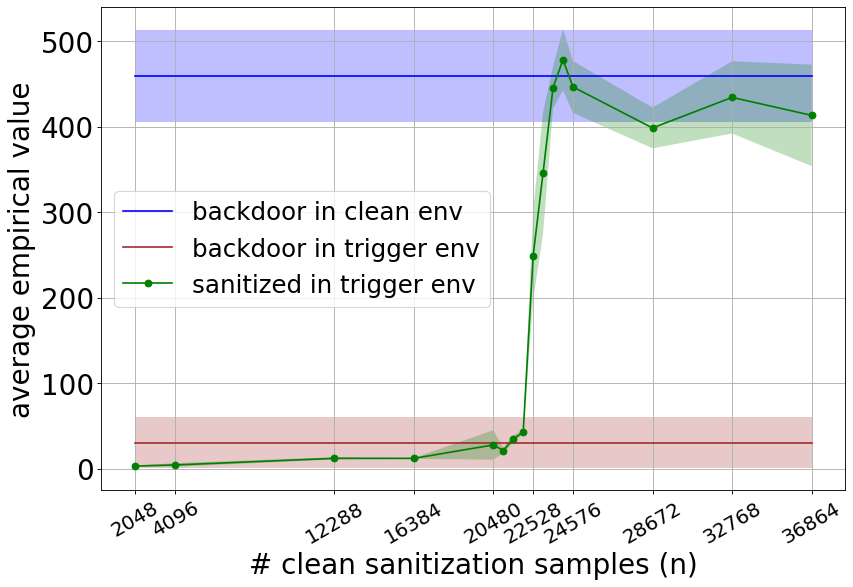

In [14]:
fig, ax = plt.subplots(figsize=(12,8), dpi=80)
plt.rcParams['font.size'] = '25'

st_return_mean_list, st_return_std_list = np.array(st_return_mean_list), np.array(st_return_std_list)
tc_return_mean_list, tc_return_std_list = np.array(tc_return_mean_list), np.array(tc_return_std_list)
tt_return_mean_list, tt_return_std_list = np.array(tt_return_mean_list), np.array(tt_return_std_list)


plt.plot(sanitizing_sample_count_list, tc_return_mean_list, color='blue', label='backdoor in clean env')
plt.plot(sanitizing_sample_count_list, tt_return_mean_list, color='brown', label='backdoor in trigger env')
plt.plot(sanitizing_sample_count_list, st_return_mean_list,  marker='.', linestyle='-', markersize=12, color='green',  label='sanitized in trigger env')

plt.fill_between(sanitizing_sample_count_list, tc_return_mean_list-tc_return_std_list, tc_return_mean_list+tc_return_std_list, facecolor='blue', alpha=0.25)
plt.fill_between(sanitizing_sample_count_list, tt_return_mean_list-tt_return_std_list, tt_return_mean_list+tt_return_std_list, facecolor='brown', alpha=0.25)
plt.fill_between(sanitizing_sample_count_list, st_return_mean_list-st_return_std_list, st_return_mean_list+st_return_std_list, facecolor='green', alpha=0.25)

plt.xlabel('# clean sanitization samples (n)', fontsize=25)
plt.ylabel('average empirical value', fontsize=25)
# plt.title('Performance of trojan')
plt.xticks(sanitizing_sample_count_list, rotation=30, fontsize=18)
plt.yticks(fontsize=25)

xticks = ax.xaxis.get_major_ticks()

for i in [5, 6, 7, 9, 10, 11]:
    xticks[i].set_visible(False)
    
# plt.title('Value of sanitized policy on triggered environment vs number of sanitization samples.')
plt.grid()
plt.legend(loc='center left', fontsize=22)
plt.savefig('performance_breakout.pdf')
plt.show()